# Решение задачи "о сезонах"

## Постановка задачи
Есть **две фотографии пейзажей с клёнами**, снятые в разных местах и в разные сезоны:
- **Photo1** — осенний пейзаж
- **Photo2** — летний пейзаж

Нужно получить:
- **Summer.jpg** = результат преобразования *Photo1 → лето*
- **Autumn.jpg** = результат преобразования *Photo2 → осень*
---

В данной работе реализован метод сегментации (маски) + локальная цветокоррекция: он даёт хороший контроль над тем, *что именно* перекрашивается, и позволяет исправлять отдельные артефакты без разрушения всего результата.



### Плюсы и минусы данного метода, сравнение с другими методами и другие важные аспекты подробно описаны в readme.md (!)

### Импорт библиотек и пути к файлам


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import src.utils.visualizer as viz


PHOTO1_PATH = "../data/task-2/Photo1.jpg"  # осень
PHOTO2_PATH = "../data/task-2/Photo2.jpg"  # лето

OUT_SUMMER = "Summer.jpg"  # Photo1 -> Summer
OUT_AUTUMN = "Autumn.jpg"  # Photo2 -> Autumn



---
## Загрузка исходных изображений и просмотр

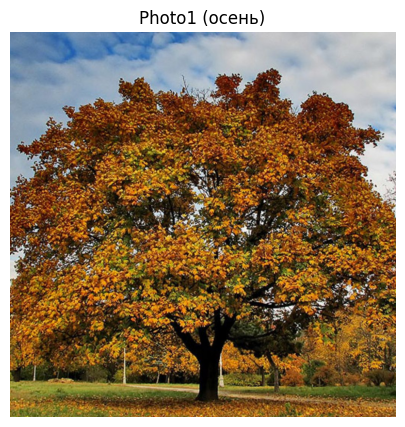

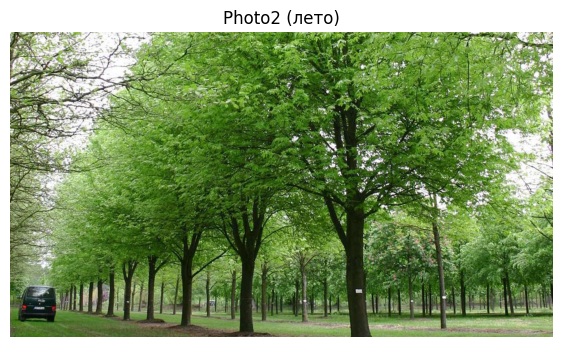

In [2]:
p1 = cv2.imread(PHOTO1_PATH, cv2.IMREAD_COLOR)  # осень
p2 = cv2.imread(PHOTO2_PATH, cv2.IMREAD_COLOR)  # лето

viz.show(p1, "Photo1 (осень)")
viz.show(p2, "Photo2 (лето)")

## Шаг 1. Маска неба/облаков (sky_mask)

Небо и облака часто имеют **синий / белый** оттенки и **не должны** перекрашиваться в «зелёный» или «оранжевый». Идея: строить маску неба в верхней части кадра, чтобы дальше её **вычитать** из любых масок растительности.

Как:
- в HSV:
  - **blue sky**: Hue 80..140, S>25, V>60 (в верхней части)
  - **clouds**: V>180, S<90 (в верхней части)

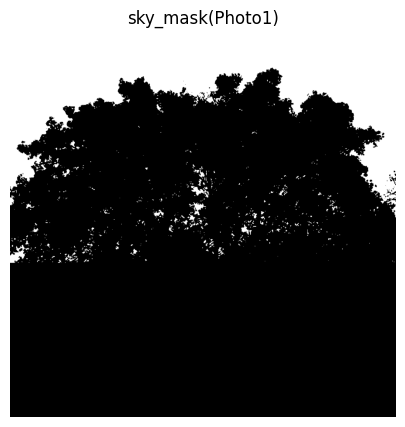

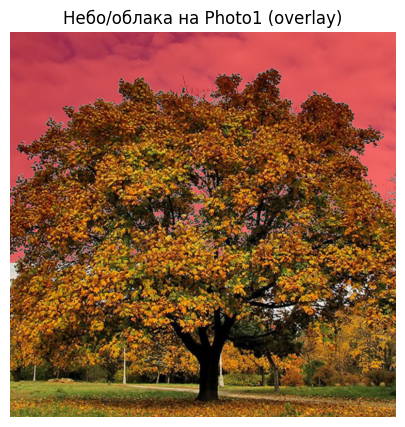

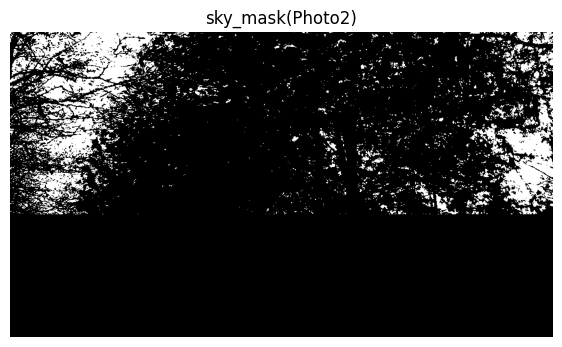

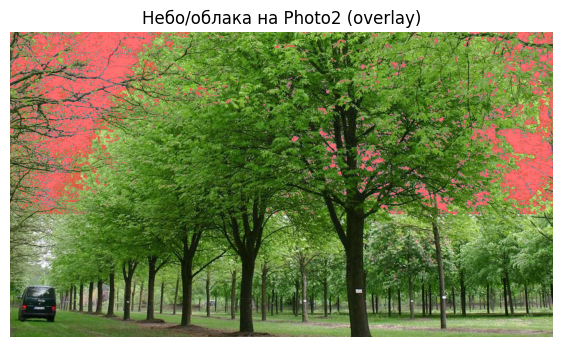

In [ ]:
from src.features.sky_mask import sky_mask

sky1 = sky_mask(p1)
sky2 = sky_mask(p2)

viz.show_mask(sky1, "sky_mask(Photo1)")
viz.show_overlay(p1, (sky1.astype(np.uint8)*255), "Небо/облака на Photo1 (overlay)")

viz.show_mask(sky2, "sky_mask(Photo2)")
viz.show_overlay(p2, (sky2.astype(np.uint8)*255), "Небо/облака на Photo2 (overlay)")

---
## Шаг 2. Вспомогательные признаки: ExG и градиент (texture)
Нам нужны два «детектора»:
1) **ExG = 2G - R - B** — хорошо подсвечивает зелёную растительность (трава, летняя крона).
2) **Модуль градиента** (Sobel) — помогает отличать «текстурные» области (крона/ветви) от ровного неба.

Эти признаки используются для построения масок кроны, земли и стволов.

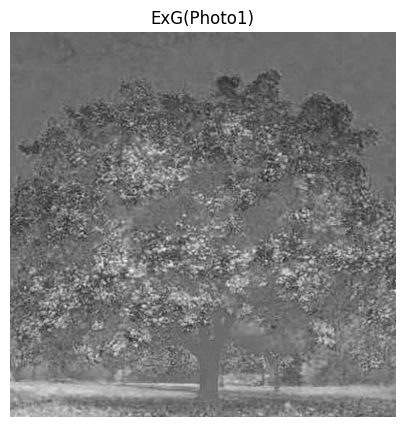

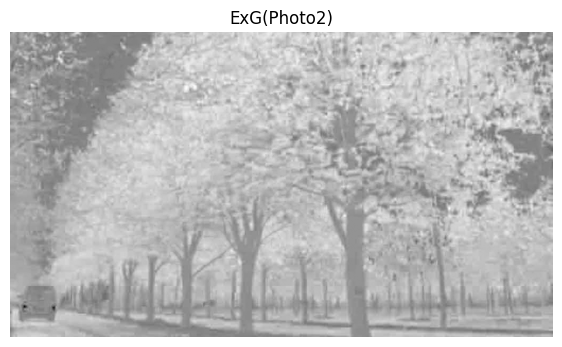

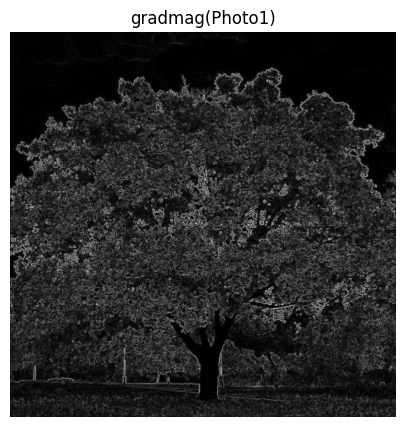

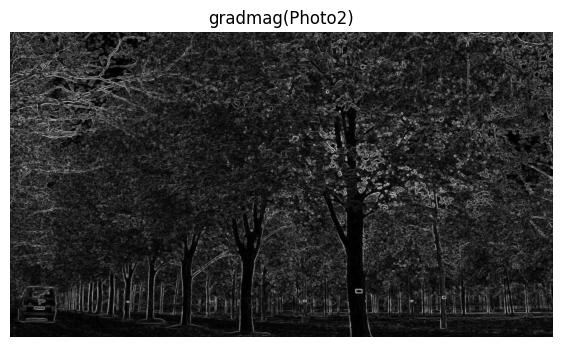

In [4]:
from src.features.exg_gradmag import exg, gradmag

g1 = exg(p1)
g2 = exg(p2)

plt.figure(figsize=(7,5)); plt.imshow(g1, cmap="gray"); plt.axis("off"); plt.title("ExG(Photo1)"); plt.show()
plt.figure(figsize=(7,5)); plt.imshow(g2, cmap="gray"); plt.axis("off"); plt.title("ExG(Photo2)"); plt.show()

gray1 = cv2.cvtColor(p1, cv2.COLOR_BGR2GRAY).astype(np.float32)
gray2 = cv2.cvtColor(p2, cv2.COLOR_BGR2GRAY).astype(np.float32)

gm1 = gradmag(gray1)
gm2 = gradmag(gray2)

plt.figure(figsize=(7,5)); plt.imshow(gm1, cmap="gray"); plt.axis("off"); plt.title("gradmag(Photo1)"); plt.show()
plt.figure(figsize=(7,5)); plt.imshow(gm2, cmap="gray"); plt.axis("off"); plt.title("gradmag(Photo2)"); plt.show()

---
## Шаг 3. Морфологические утилиты для масок

Маски строятся эвристически, поэтому нужно **исправлять неточности** (например, «просветы» неба внутри кроны)


In [5]:
from src.features.fill_holes import fill_holes, remove_small

## Шаг 4. Маска стволов/веток (trunk_mask)

Стволы и ветки **не являются листвой** и не должны получать зелёный или оранжевый как листва.

Идея:
- исключается небо (`~sky`)
- выбираются области с **низкой насыщенностью** `S < 80` и **умеренной яркостью** `20 < V < 165`
- добавляется условие на **градиент** (есть структура)

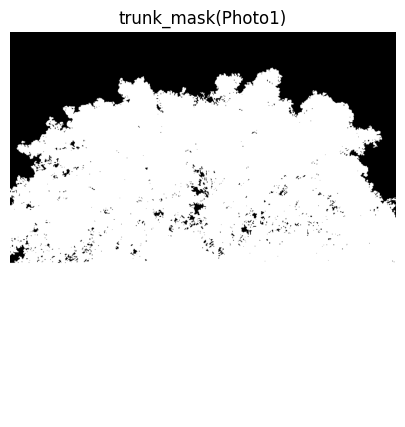

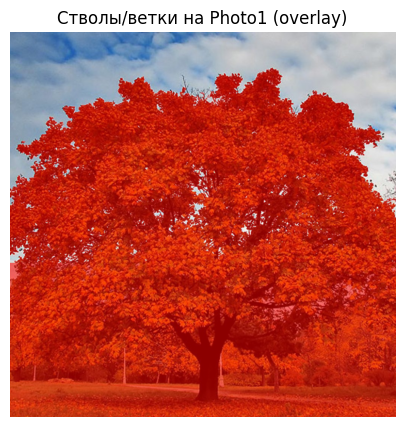

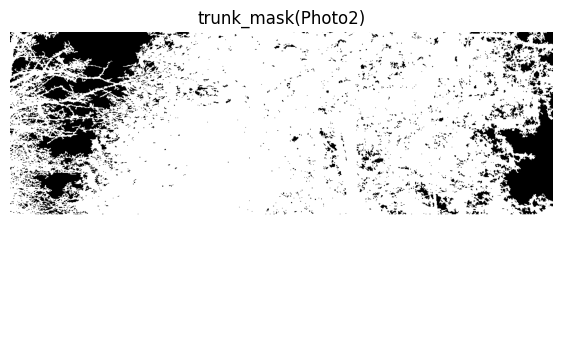

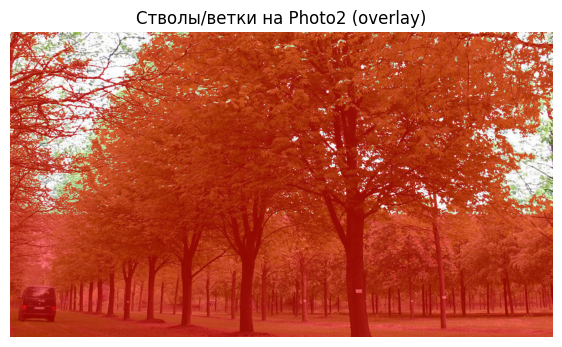

In [6]:
from src.features.trunk_mask import trunk_mask

tr1 = trunk_mask(p1, sky1)
tr2 = trunk_mask(p2, sky2)

viz.show_mask(tr1, "trunk_mask(Photo1)")
viz.show_overlay(p1, tr1, "Стволы/ветки на Photo1 (overlay)")

viz.show_mask(tr2, "trunk_mask(Photo2)")
viz.show_overlay(p2, tr2, "Стволы/ветки на Photo2 (overlay)")

## Шаг 5. Маски кроны и земли для каждого сезона

Мы делим «то, что меняем» на две большие зоны:
1) **Крона** (верх кадра) — листья на деревьях
2) **Земля** (низ кадра) — трава летом, ковёр листьев осенью

Это позволяет:
- менять их **по разным референсам** (крона↔крона, земля↔земля)
- не трогать стволы и небо

Ниже — четыре маски:
- `fol1`: осенняя крона на Photo1
- `gnd1`: осенняя земля на Photo1
- `fol2`: летняя крона на Photo2
- `gnd2`: летняя трава на Photo2

In [ ]:
from src.features.fol_ground import foliage_mask_autumn, ground_warm_mask_autumn, foliage_mask_summer, ground_grass_mask_summer

fol1 = foliage_mask_autumn(p1, sky1, tr1)
gnd1 = ground_warm_mask_autumn(p1, sky1, tr1)

fol2 = foliage_mask_summer(p2, sky2, tr2)
gnd2 = ground_grass_mask_summer(p2, sky2, tr2)



---
## Шаг 6. Построение «плавной альфы» с защитой неба

Маски бинарные, а границы должны быть мягкими, иначе появятся «вырезанные» края.

Также дополнительно защищаем очень яркие и малонасыщенные пиксели (облака/просветы).

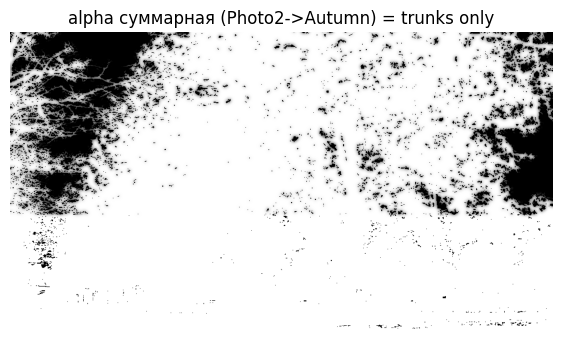

In [ ]:
from src.features.protect_bright import protect_bright, feather_alpha_sky

alpha_summer = np.zeros(p1.shape[:2], dtype=np.float32)
alpha_summer[sky1] = 0.0
a_t2 = np.clip(cv2.GaussianBlur((tr2 > 0).astype(np.float32), (19, 19), 0), 0.0, 1.0)
a_t2[sky2] = 0.0
a_t2 = protect_bright(a_t2, p2)  # доп. защита ярких облаков

alpha_autumn = np.clip(a_t2, 0.0, 1.0)

viz.show_alpha(alpha_autumn, "alpha суммарная (Photo2->Autumn) = trunks only")

---
## Шаг 7. Математика цветового переноса в HSV

Работа в HSV потому что:
- **Hue** отвечает за тон,
- **S** за насыщенность,
- **V** за яркость.

Чтобы сделать «лето ↔ осень» естественным, необходимо:
1) **Поменять Hue в нужный диапазон**
2) **Указать S,V по статистике референса** (mean/std matching) и смешивать с исходными, чтобы не получить неон.

Ниже — два преобразования:
- `recolor_hsv_region`: сдвиг Hue к среднему референса + клип в заданный диапазон
- `map_green_to_autumn`: явный маппинг зелёного Hue (28..105) → (10..32)

In [9]:
from src.features.recoloring import recolor_hsv_region, map_green_to_autumn

---
## Шаг 8. Специальная обработка стволов в «Autumn» (degreen_trunks)
Это отдельный, очень контролируемый шаг:  **стволы зеленеют**, когда рядом зелёная листва и общий перенос/смешивание затрагивает и их.

In [10]:
from src.features.recoloring import degreen_trunks

---
## Шаг 9. Смешивание (blend)
Смешиваем базовое изображение и перекрашенный вариант по альфе:
- `alpha=1` → полностью берём «changed»
- `alpha=0` → оставляем «base»

In [11]:
def blend(base_bgr: np.ndarray, changed_bgr: np.ndarray, alpha: np.ndarray) -> np.ndarray:
    out = changed_bgr.astype(np.float32) * alpha[..., None] + base_bgr.astype(np.float32) * (1.0 - alpha[..., None])
    return np.clip(out, 0, 255).astype(np.uint8)

---
# Полный пайплайн

## A) Photo1 (осень) → Summer
1) Перекрасить крону `fol1` в зелёный диапазон (ориентируясь на летнюю крону `fol2`)
2) Перекрасить землю `gnd1` в зелёный диапазон (ориентируясь на летнюю траву `gnd2`)
3) Построить альфу для кроны и земли, защитить небо и яркие «просветы»
4) Смешать с исходным изображением

Ниже — **визуализация после каждого шага**.

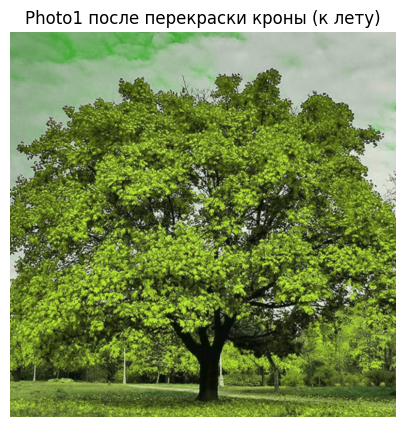

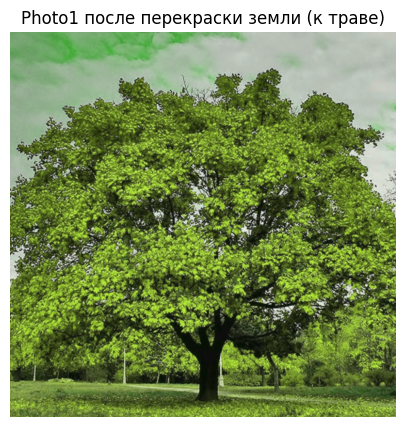

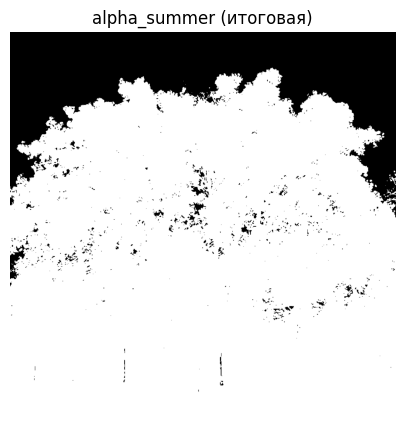

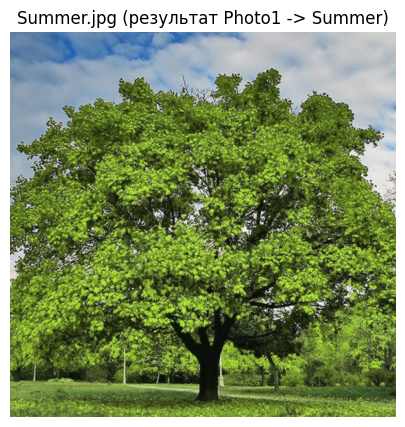

In [12]:
step = p1.copy()

# 1) крона -> зелень
step1 = recolor_hsv_region(
    step, fol1, p2, fol2,
    target_h_range=(38.0, 56.0),
    sv_strength=0.85,
    clamp_s=(15, 220),
    clamp_v=(10, 240),
)
viz.show(step1, "Photo1 после перекраски кроны (к лету)")

# 2) земля -> трава
step2 = recolor_hsv_region(
    step1, gnd1, p2, gnd2,
    target_h_range=(38.0, 70.0),
    sv_strength=0.90,
    clamp_s=(10, 200),
    clamp_v=(10, 245),
)
viz.show(step2, "Photo1 после перекраски земли (к траве)")

# 3) альфа
a_f = protect_bright(feather_alpha_sky(fol1, sky1, radius=27, erode_px=4), p1)
a_g = protect_bright(feather_alpha_sky(gnd1, sky1, radius=31, erode_px=6), p1)
alpha_summer = np.clip(a_f + a_g * 0.95, 0.0, 1.0)

viz.show_alpha(alpha_summer, "alpha_summer (итоговая)")

# 4) финальный blend
summer_img = blend(p1, step2, alpha_summer)
viz.show(summer_img, "Summer.jpg (результат Photo1 -> Summer)")

---
## B) Photo2 (лето) → Autumn
1) Крона `fol2`: зелёный → осенний диапазон Hue (по осенней кроне `fol1`)
2) Земля/трава `gnd2`: зелёный → осенний (по осенней земле `gnd1`)
3) Стволы `tr2`: убрать зелень + перекрасить древесину
4) Альфа для кроны/земли/стволов, небо всегда 0
5) Смешивание

Ниже — визуализация по шагам.

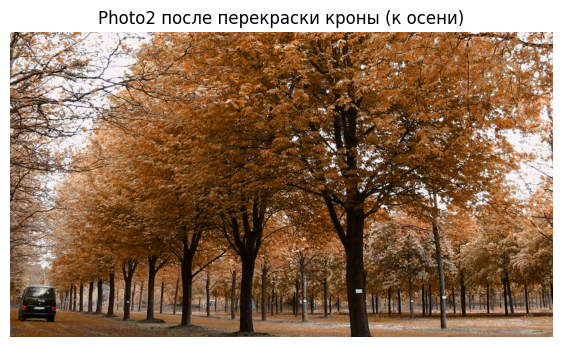

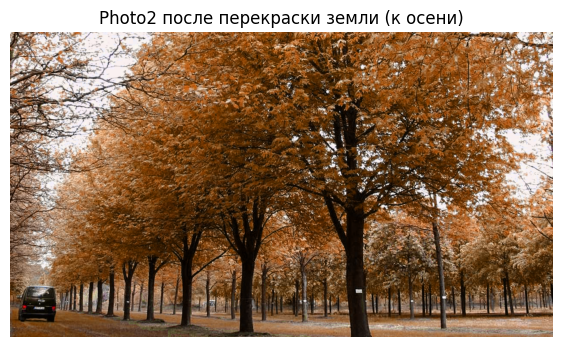

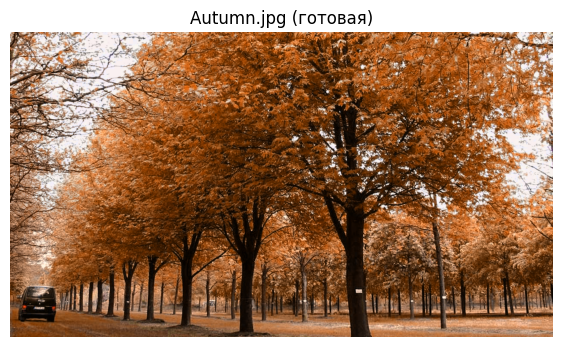

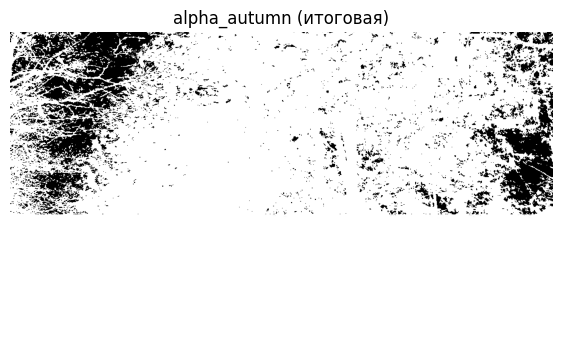

In [13]:
stepA = p2.copy()

# 1) крона: зелёный -> осень
stepA1 = map_green_to_autumn(stepA, fol2, p1, fol1, out_range=(10.0, 32.0), sv_strength=0.85)
viz.show(stepA1, "Photo2 после перекраски кроны (к осени)")

# 2) земля/трава: зелёный -> осень
stepA2 = map_green_to_autumn(stepA1, gnd2, p1, gnd1, out_range=(12.0, 30.0), sv_strength=0.85)
viz.show(stepA2, "Photo2 после перекраски земли (к осени)")

# 3) стволы
autumn_img = degreen_trunks(stepA2, tr2, warmth=0.55)
viz.show(autumn_img, "Autumn.jpg (готовая)")

# 4) альфа
a_f2 = protect_bright(feather_alpha_sky(fol2, sky2, radius=25, erode_px=2), p2)
a_g2 = protect_bright(feather_alpha_sky(gnd2, sky2, radius=29, erode_px=3), p2)
a_t2 = np.clip(cv2.GaussianBlur((tr2 > 0).astype(np.float32), (19, 19), 0), 0.0, 1.0)
a_t2[sky2] = 0.0

alpha_autumn = np.clip(a_f2 + a_g2 * 0.95 + a_t2, 0.0, 1.0)
viz.show_alpha(alpha_autumn, "alpha_autumn (итоговая)")


---
## Сохранение результатов

In [14]:
cv2.imwrite(OUT_SUMMER, summer_img, [int(cv2.IMWRITE_JPEG_QUALITY), 95])
cv2.imwrite(OUT_AUTUMN, autumn_img, [int(cv2.IMWRITE_JPEG_QUALITY), 95])

print("  saved ->", os.path.abspath(OUT_SUMMER))
print("  saved ->", os.path.abspath(OUT_AUTUMN))

  saved -> c:\Projects\Petropolitan-Science-Re-Search-2025-26\task_2\Summer.jpg
  saved -> c:\Projects\Petropolitan-Science-Re-Search-2025-26\task_2\Autumn.jpg


---
# Итоги: качество, плюсы и минусы

## Что получилось хорошо
- **Листва и трава** переходят в нужный сезонный оттенок, потому что мы работаем с Hue/S/V и опираемся на статистику референса.
- **Небо и облака защищены**: для них всегда `alpha=0`, дополнительно защищаются «яркие пробелы».
- **Стволы не зеленеют в Autumn**: отдельная маска стволов + отдельный шаг `degreen_trunks`.

## Достоинства алгоритма
- Быстрый (CPU), без обучения, детерминированный.
- Объяснимый: каждый шаг интерпретируем (маска → преобразование → мягкое смешивание).
- Локальные исправления не ломают весь результат (например, отдельный фикс стволов).

## Недостатки
- На других фото может потребоваться перенастройка порогов и размеров морфологии.
- Мы меняем цвет, но не «генерируем» новые сезонные детали (например, опавшие листья там, где их не было).
